Data and parameters

In [67]:
# Input
bids_data_path = 'D:/Coursework/NeuroComp2025_TPFinal/Data/BIDS_Behavior'
timeseries_path = 'D:/Coursework/NeuroComp2025_TPFinal/Data/TimeSeries'
atlas_file = 'D:/Coursework/NeuroComp2025_TPFinal/Data/Atlas/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S2_MNI152NLin6Asym_2mm.nii.gz'
atlas_labels_file = 'D:/Coursework/NeuroComp2025_TPFinal/Data/Atlas/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S2_label.txt'

tr = 0.5

excluded_subjects_id = ['06', '12', '15', '21', '42', '44']

n_early_blocks_by_task = {
    'mslWithITI': 4,
    'mslWithoutITI': 6
}
n_late_blocks_by_task = {
    'mslWithITI': 24,
    'mslWithoutITI': 22
}

# Amount of TR to shift the time series to account for HRF delay
shift_n_tr = 10 # 5s for TR=0.5s

alpha = 0.05

Dependencies

In [1]:
'''%pip install nilearn
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pybids
%pip install networkx'''

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import networkx as nx
from scipy import stats
from bids import BIDSLayout
from nilearn import plotting


Auxiliary functions for processing images and behavior, and extracting timeseries

In [3]:
def load_events(events_file):
    return pd.read_table(events_file, sep='\t')

def load_timeseries(file):
    return np.genfromtxt(file).transpose()

def add_baseline(events_df):
    new_df = events_df.copy()
    new_df.loc[-1] = [0.0, new_df['onset'].min() , 'baseline', 0]
    new_df.index = new_df.index + 1
    new_df.sort_index(inplace=True) 
    return new_df

def add_amplitude(events_df):
    new_df = events_df.copy()
    new_df['amplitude'] = 1.0
    return new_df

def onsets_to_tr(events_df, tr):
    new_df = events_df.copy()
    new_df['tr_start'] = (new_df['onset'] / tr).round().astype(int)
    
    tr_durations = new_df['tr_start'].shift(-1, fill_value=-1) -  new_df['tr_start'] - 1
    tr_durations.iloc[-1] = (new_df['duration'].iloc[-1] / tr).astype(int) - 1
    new_df['tr_duration'] = tr_durations

    new_df['tr_end'] = new_df['tr_start'] + new_df['tr_duration']
    return new_df

def shift_tr(events_df, shift_n_tr, max_volumes):
    new_df = events_df.copy()
    new_df['tr_start'] += shift_n_tr
    new_df['tr_end'] += shift_n_tr
    new_df.loc[new_df['trial_type']=='baseline', 'tr_start'] = 0
    new_df.loc[new_df['tr_start'] > max_volumes, 'tr_start'] = max_volumes
    new_df.loc[new_df['tr_end'] > max_volumes, 'tr_end'] = max_volumes
    new_df['tr_duration'] = new_df['tr_end'] - new_df['tr_start']
    return new_df

def classify_stage(events_df, n_early_blocks, n_late_blocks, column='block_n'):
    new_df = events_df.copy()
    stage = []
    for index, row in new_df.iterrows():
        block = row[column]
        if block > 0 and block <= n_early_blocks:
            stage.append('early')
        elif block > 0 and block >= (new_df[column].max()-n_late_blocks+1):
            stage.append('late')
        else:
            stage.append(pd.NA)
    new_df['stage'] = stage
    return new_df

def get_blocks(events_df, condition=None, stage=None):
    if condition is not None:
        if stage is not None:
            return events_df[(events_df['trial_type'] == condition) & (events_df['stage'] == stage)]
        else:
            return events_df[events_df['trial_type'] == condition]
    if stage is not None:
        return events_df[events_df['stage'] == stage]
    return events_df

def filter_timeseries(timeseries, events_df, start_column='tr_start', end_column='tr_end'):
    keep_columns = []
    for start, end in zip(events_df[start_column], events_df[end_column]):
        keep_columns += list(np.arange(start, end))
    return timeseries[:,keep_columns]


Timeseries extraction

In [ ]:
layout = BIDSLayout(bids_data_path, validate=False)

subjects = layout.get_subjects()

timeseries_data = {}

for sub_id in subjects:
    if sub_id in excluded_subjects_id:
        print(f'Skipping excluded subject sub-{sub_id}')
        continue
    print(f'Extracting data from subject sub-{sub_id}')
    
    # Get events file
    events_file = layout.get(
        subject = sub_id,
        suffix = 'events',
        extension = '.tsv'
    )[0]
    entities = events_file.entities # For the task id
    events_file = events_file.path # BIDS object to path

    task_id = entities['task']

    # Get timeseries file
    timeseries_file = os.path.join(timeseries_path, f'sub-{sub_id}_task-{task_id}_desc-clean_timeseries.tsv')

    # Load timeseries
    timeseries = load_timeseries(timeseries_file)
    n_volumes = timeseries.shape[1]
    n_volumes=1700
    
    # Load onsets and prepare dataframe
    n_early_blocks = n_early_blocks_by_task[task_id]
    n_late_blocks = n_late_blocks_by_task[task_id]
    events = load_events(events_file)
    events = add_baseline(events)
    events = add_amplitude(events)
    events = classify_stage(events, n_early_blocks, n_late_blocks)
    events = onsets_to_tr(events, tr)
    events = shift_tr(events, shift_n_tr, n_volumes)

    # Filter blocks
    events_baseline = get_blocks(events, condition='baseline')
    events_rest = get_blocks(events, condition='rest')
    events_task = get_blocks(events, condition='task')
    events_early = get_blocks(events, stage='early')
    events_late = get_blocks(events, stage='late')
    events_rest_early = get_blocks(events, condition='rest', stage='early')
    events_rest_late = get_blocks(events, condition='rest', stage='late') 
    events_task_early = get_blocks(events, condition='task', stage='early') 
    events_task_late = get_blocks(events, condition='task', stage='late') 
    
    # Filter timeseries
    timeseries_baseline = filter_timeseries(timeseries, events_baseline)
    timeseries_rest = filter_timeseries(timeseries, events_rest)
    timeseries_task = filter_timeseries(timeseries, events_task)
    timeseries_early = filter_timeseries(timeseries, events_early)
    timeseries_late = filter_timeseries(timeseries, events_late)
    timeseries_rest_early = filter_timeseries(timeseries, events_rest_early)
    timeseries_rest_late = filter_timeseries(timeseries, events_rest_late)
    timeseries_task_early = filter_timeseries(timeseries, events_task_early)
    timeseries_task_late = filter_timeseries(timeseries, events_task_late)

    if task_id not in timeseries_data:
        timeseries_data[task_id] = {}
    if sub_id not in timeseries_data[task_id]:
        timeseries_data[task_id][sub_id] = {}
    timeseries_data[task_id][sub_id]['baseline'] = timeseries_baseline
    timeseries_data[task_id][sub_id]['rest'] = timeseries_rest
    timeseries_data[task_id][sub_id]['task'] = timeseries_task
    timeseries_data[task_id][sub_id]['early'] = timeseries_early
    timeseries_data[task_id][sub_id]['late'] = timeseries_late
    timeseries_data[task_id][sub_id]['rest_early'] = timeseries_rest_early
    timeseries_data[task_id][sub_id]['rest_late'] = timeseries_rest_late
    timeseries_data[task_id][sub_id]['task_early'] = timeseries_task_early
    timeseries_data[task_id][sub_id]['task_late'] = timeseries_task_late
print('Done')
    
    

Extracting data from subject sub-01
Extracting data from subject sub-02
Extracting data from subject sub-03
Extracting data from subject sub-04
Extracting data from subject sub-05
Extracting data from subject sub-08
Extracting data from subject sub-09
Extracting data from subject sub-10
Extracting data from subject sub-11
Skipping excluded subject sub-12
Extracting data from subject sub-13
Extracting data from subject sub-14
Skipping excluded subject sub-15
Extracting data from subject sub-16
Extracting data from subject sub-17
Extracting data from subject sub-18
Extracting data from subject sub-19
Extracting data from subject sub-20
Skipping excluded subject sub-21
Extracting data from subject sub-22
Extracting data from subject sub-23
Extracting data from subject sub-24
Extracting data from subject sub-26
Extracting data from subject sub-27
Extracting data from subject sub-28
Extracting data from subject sub-29
Extracting data from subject sub-30
Extracting data from subject sub-31
E

Auxiliary functions for analysis and graph handling

In [ ]:
def load_labels(file):
    fi = open(file, 'rt')
    lines = fi.readlines()
    fi.close()
    return [lines[i].strip() for i in range(0,len(lines),2)]

def get_labels_coordinates(atlas_file):
    return plotting.find_parcellation_cut_coords(atlas_file)

def color_labels(labels):
    colors = []
    for label in labels:
        if '_Vis_' in label:
            colors.append('purple')
        elif '_SomMot_' in label:
            colors.append('blue')
        elif '_DorsAttn_' in label:
            colors.append('green')
        elif '_SalVentAttn_' in label:
            colors.append('pink')
        elif '_Limbic_' in label:
            colors.append('olive')
        elif '_Limbic_' in label:
            colors.append('olive')
        elif '_Cont_' in label:
            colors.append('red')
        elif '_Default_' in label:
            colors.append('orange')
        elif 'HIP' in label:
            colors.append('k')
        else:
            colors.append('gray')
    return colors

def get_relabel_mapping(labels):
    mapping = {}
    for i in range(len(labels)):
        mapping[i] = labels[i]
    return mapping

def classify_label(labels):
    for label in labels:
        pass

def get_edge_weigths(graph):
    weights = {}
    for edge in graph.edges(data=True):
        weights[(edge[0], edge[1])] = edge[-1]['weight']
    return weights

def draw_results_graph(adj_matrix, alpha, relabel_map, colors):
    g = nx.from_numpy_array((adj_matrix < alpha) * 1)
    g = nx.relabel_nodes(g, relabel_map)

    pos = nx.circular_layout(g)
    return nx.draw(
        g,
        pos=pos,
        node_size= 15,
        node_color=colors,
        width=0.2)




Get adjacency matrices

In [637]:
labels = load_labels(atlas_labels_file)
relabel_mapping = get_relabel_mapping(labels)
label_colors = color_labels(labels)
label_coords = get_labels_coordinates(atlas_file)

adjacency_matrices = {}

for task_id in timeseries_data:
    for sub_id in timeseries_data[task_id]:
        for filtered in timeseries_data[task_id][sub_id]:
            print(f'Computing correlation matrix for {filtered} data for subject sub-{sub_id} ({task_id})')
            ts = timeseries_data[task_id][sub_id][filtered]

            corr = np.corrcoef(ts)
            np.fill_diagonal(corr, 0)
            z_score = np.arctanh(corr)
            #plt.imshow(z_score, cmap='RdBu', vmin=-2, vmax=2)
            #plt.colorbar()
            #plt.show()
            
            if filtered not in adjacency_matrices:
                adjacency_matrices[filtered] = {}
            if task_id not in adjacency_matrices[filtered]:
                adjacency_matrices[filtered][task_id] = [z_score]
            else:
                adjacency_matrices[filtered][task_id] += [z_score]

Computing correlation matrix for baseline data for subject sub-01 (mslWithITI)
Computing correlation matrix for rest data for subject sub-01 (mslWithITI)
Computing correlation matrix for task data for subject sub-01 (mslWithITI)
Computing correlation matrix for early data for subject sub-01 (mslWithITI)
Computing correlation matrix for late data for subject sub-01 (mslWithITI)
Computing correlation matrix for rest_early data for subject sub-01 (mslWithITI)
Computing correlation matrix for rest_late data for subject sub-01 (mslWithITI)
Computing correlation matrix for task_early data for subject sub-01 (mslWithITI)
Computing correlation matrix for task_late data for subject sub-01 (mslWithITI)
Computing correlation matrix for baseline data for subject sub-02 (mslWithITI)
Computing correlation matrix for rest data for subject sub-02 (mslWithITI)
Computing correlation matrix for task data for subject sub-02 (mslWithITI)
Computing correlation matrix for early data for subject sub-02 (mslWi

Within subject edge analysis: early vs. late learning

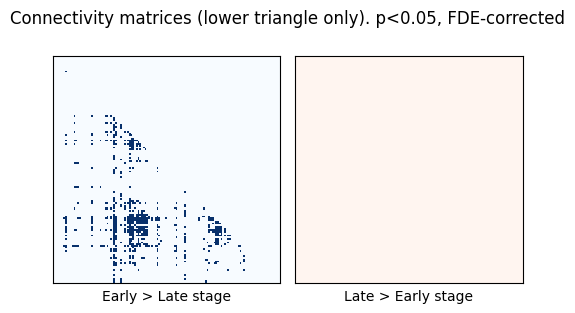

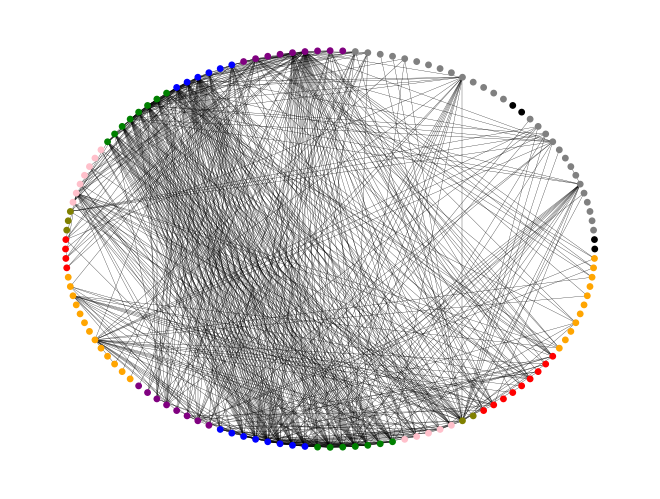

In [ ]:
# Get early and late data for all subjects
early_data = adjacency_matrices['early']['mslWithITI'] + adjacency_matrices['early']['mslWithoutITI']
late_data = adjacency_matrices['late']['mslWithITI'] + adjacency_matrices['late']['mslWithoutITI']

# Get lower triangles
early_data = [np.tril(m) for m in early_data]
late_data = [np.tril(m) for m in late_data]

# Compute a two-sample t-test and convert nans to 1 (so it's accepted by the FDR control function)
within_subjects_results = {
    'early>late (uncorrected)': np.nan_to_num(stats.ttest_ind(early_data, late_data, alternative='greater').pvalue, nan=1),
    'late>early (uncorrected)': np.nan_to_num(stats.ttest_ind(early_data, late_data, alternative='less').pvalue, nan=1)
}

# Apply Bonferroni correction
within_subjects_results['early>late (FDE-corrected)'] = stats.false_discovery_control(within_subjects_results['early>late (uncorrected)'])
within_subjects_results['late>early (FDE-corrected)'] = stats.false_discovery_control(within_subjects_results['late>early (uncorrected)'])

alpha = 0.05

fig, axs = plt.subplots(1, 2, figsize=(5,3))
fig.suptitle('Connectivity matrices (lower triangle only). p<0.05, FDE-corrected')

axs[0].imshow(within_subjects_results['early>late (FDE-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[1].imshow(within_subjects_results['late>early (FDE-corrected)']<alpha, cmap='Reds', interpolation='none')


axs[0].set(xlabel='Early > Late stage')
axs[1].set(xlabel='Late > Early stage')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

draw_results_graph(within_subjects_results['early>late (FDE-corrected)'], alpha, relabel_mapping, label_colors)

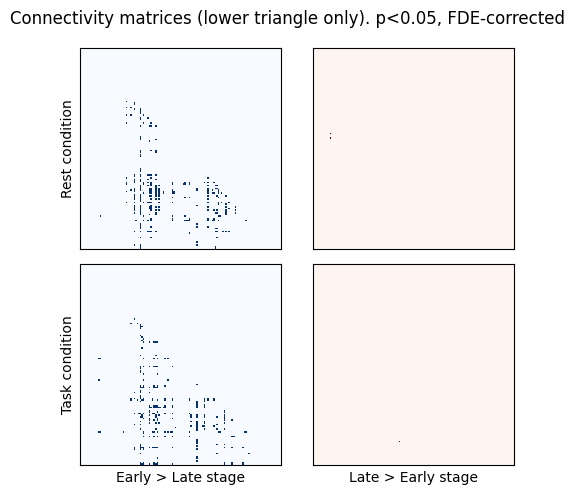

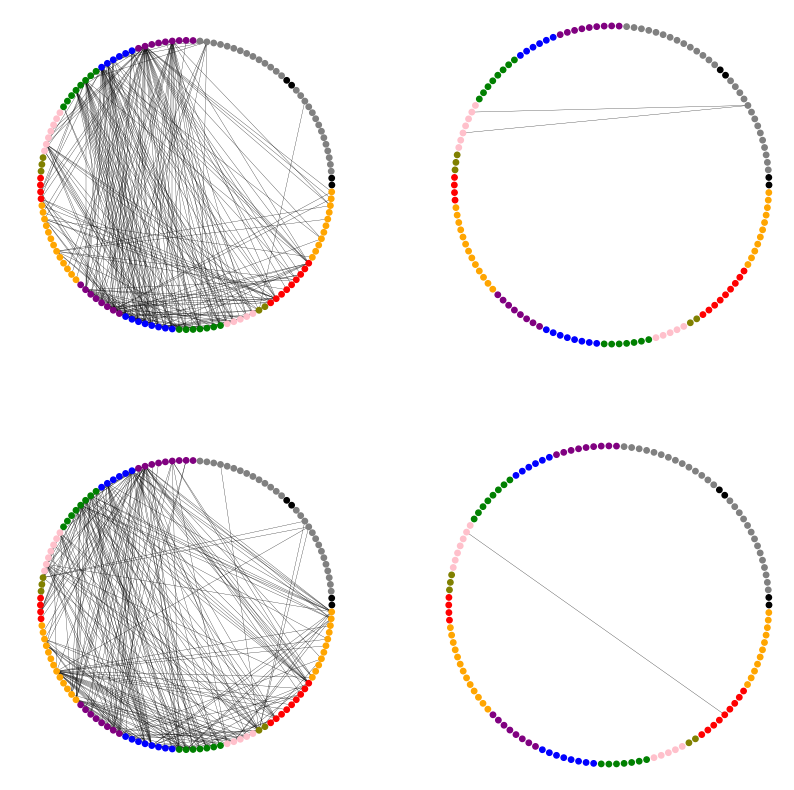

In [673]:
# Get early and late data for all subjects
rest_early_data = adjacency_matrices['rest_early']['mslWithITI'] + adjacency_matrices['rest_early']['mslWithoutITI']
rest_late_data = adjacency_matrices['rest_late']['mslWithITI'] + adjacency_matrices['rest_late']['mslWithoutITI']

task_early_data = adjacency_matrices['task_early']['mslWithITI'] + adjacency_matrices['task_early']['mslWithoutITI']
task_late_data = adjacency_matrices['task_late']['mslWithITI'] + adjacency_matrices['task_late']['mslWithoutITI']

# Get lower triangles
rest_early_data = [np.tril(m) for m in rest_early_data]
rest_late_data = [np.tril(m) for m in rest_late_data]
task_early_data = [np.tril(m) for m in task_early_data]
task_late_data = [np.tril(m) for m in task_late_data]

# Compute a two-sample t-test and convert nans to 1 (so it's accepted by the FDR control function)
within_subjects_results = {
    'Rest: early > late (uncorrected)': np.nan_to_num(stats.ttest_ind(rest_early_data, rest_late_data, alternative='greater').pvalue, nan=1),
    'Rest: late > early (uncorrected)': np.nan_to_num(stats.ttest_ind(rest_early_data, rest_late_data, alternative='less').pvalue, nan=1),
    'Task: early > late (uncorrected)': np.nan_to_num(stats.ttest_ind(task_early_data, task_late_data, alternative='greater').pvalue, nan=1),
    'Task: late > early (uncorrected)': np.nan_to_num(stats.ttest_ind(task_early_data, task_late_data, alternative='less').pvalue, nan=1)
}

# Apply Bonferroni correction
within_subjects_results['Rest: early > late (FDR-corrected)'] = stats.false_discovery_control(within_subjects_results['Rest: early > late (uncorrected)'])
within_subjects_results['Rest: late > early (FDR-corrected)'] = stats.false_discovery_control(within_subjects_results['Rest: late > early (uncorrected)'])
within_subjects_results['Task: early > late (FDR-corrected)'] = stats.false_discovery_control(within_subjects_results['Task: early > late (uncorrected)'])
within_subjects_results['Task: late > early (FDR-corrected)'] = stats.false_discovery_control(within_subjects_results['Task: late > early (uncorrected)'])

alpha = 0.05

fig, axs = plt.subplots(2, 2, figsize=(5,5))
fig.suptitle('Connectivity matrices (lower triangle only). p<0.05, FDE-corrected')

axs[0,0].imshow(within_subjects_results['Rest: early > late (FDR-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[0,1].imshow(within_subjects_results['Rest: late > early (FDR-corrected)']<alpha, cmap='Reds', interpolation='none')
axs[1,0].imshow(within_subjects_results['Task: early > late (FDR-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[1,1].imshow(within_subjects_results['Task: late > early (FDR-corrected)']<alpha, cmap='Reds', interpolation='none')


axs[0,0].set(ylabel='Rest condition')
axs[1,0].set(ylabel='Task condition')
axs[1,0].set(xlabel='Early > Late stage')
axs[1,1].set(xlabel='Late > Early stage')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
draw_results_graph(within_subjects_results['Rest: early > late (FDR-corrected)'], alpha, relabel_mapping, label_colors)
plt.subplot(2,2,2)
draw_results_graph(within_subjects_results['Rest: late > early (FDR-corrected)'], alpha, relabel_mapping, label_colors)
plt.subplot(2,2,3)
draw_results_graph(within_subjects_results['Task: early > late (FDR-corrected)'], alpha, relabel_mapping, label_colors)
plt.subplot(2,2,4)
draw_results_graph(within_subjects_results['Task: late > early (FDR-corrected)'], alpha, relabel_mapping, label_colors)

In [722]:
def compute_node_metrics(adj_matrix_list):
    strength = []
    bwcent = []
    clust = []
    for m in adj_matrix_list:
        g = nx.from_numpy_array(m)
        strength.append([ v for k,v in (nx.degree(g, weight='weight')) ])
        #bwcent.append([ v for v in (nx.betweenness_centrality(g, weight='weight')).values() ])
        clust.append([ v for v in (nx.clustering(g, weight='weight')).values() ])

    metrics = {}
    metrics['strength'] = pd.DataFrame(strength)
    #metrics['betweenness centrality'] = pd.DataFrame(bwcent)
    metrics['clustering coefficient'] = pd.DataFrame(clust)
    return metrics


# Within subject node analysis: early vs. late learning

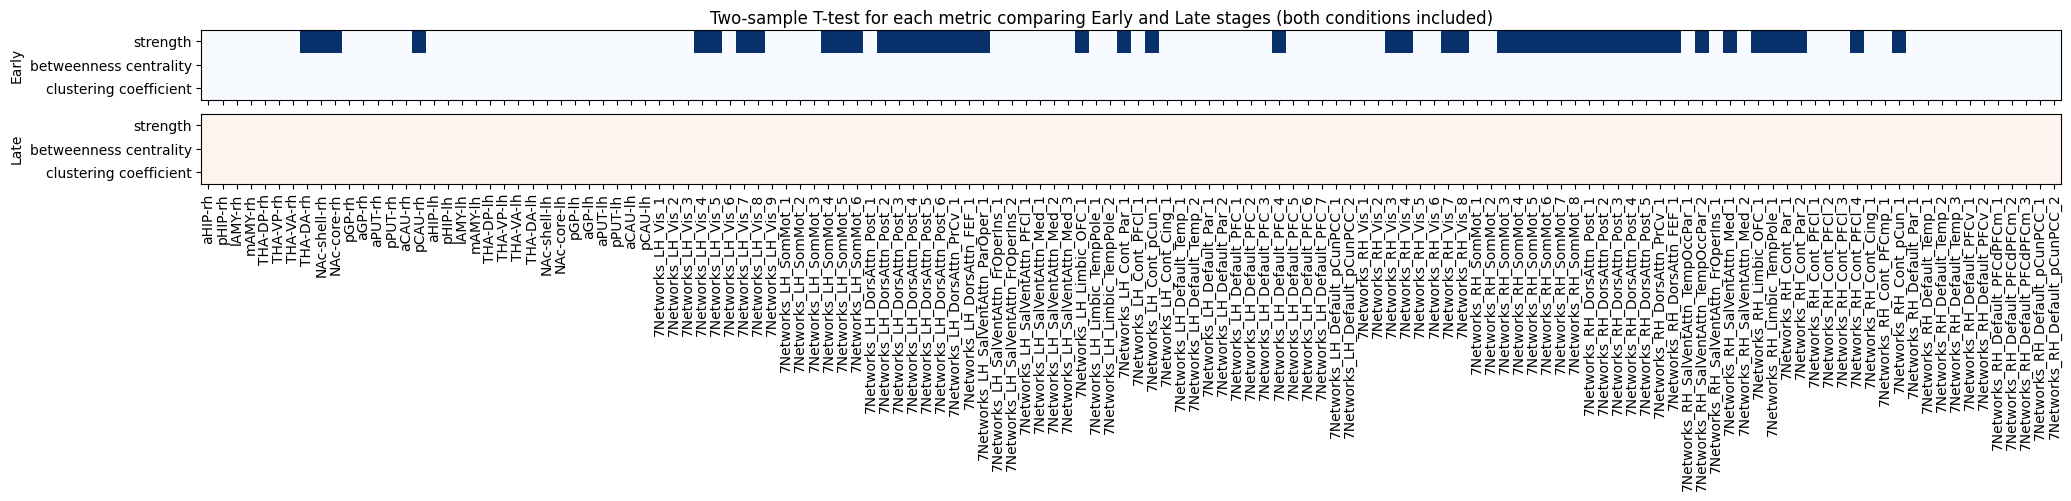

In [ ]:
early_data = adjacency_matrices['early']['mslWithITI'] + adjacency_matrices['early']['mslWithoutITI']
late_data = adjacency_matrices['late']['mslWithITI'] + adjacency_matrices['late']['mslWithoutITI']

early_metrics = compute_node_metrics(early_data)
late_metrics = compute_node_metrics(late_data)

early_late_stats = {}
for metric in early_metrics:
    early_late_stats[metric] = {}
    p_vals_early = stats.ttest_ind(early_metrics[metric], late_metrics[metric], alternative='greater').pvalue
    p_vals_late = stats.ttest_ind(early_metrics[metric], late_metrics[metric], alternative='less').pvalue
    p_vals_fdr_early = stats.false_discovery_control(p_vals_early)
    p_vals_fdr_late = stats.false_discovery_control(p_vals_late)
    early_late_stats[metric]['early > late'] = p_vals_fdr_early
    early_late_stats[metric]['late > early'] = p_vals_fdr_late

alpha = 0.05

fig, axs = plt.subplots(2,1,figsize=(24, 2))
axs[0].imshow([
    early_late_stats['strength']['early > late'] < alpha,
    early_late_stats['betweenness centrality']['early > late'] < alpha,
    early_late_stats['clustering coefficient']['early > late'] < alpha
    ], interpolation='none', aspect='auto', cmap='Blues')

axs[1].imshow([
    early_late_stats['strength']['late > early'] < alpha,
    early_late_stats['betweenness centrality']['late > early'] < alpha,
    early_late_stats['clustering coefficient']['late > early'] < alpha
    ], interpolation='none', aspect='auto', cmap='Reds')

fig.suptitle('Two-sample T-test for each metric comparing Early and Late stages (both conditions included)')
axs[0].set(yticks=[0,1,2], yticklabels=['strength', 'betweenness centrality', 'clustering coefficient'])
axs[0].set(xticks=np.arange(len(labels)))
axs[0].set(ylabel='Early')
axs[1].set(yticks=[0,1,2], yticklabels=['strength', 'betweenness centrality', 'clustering coefficient'])
axs[1].set(xticks=np.arange(len(labels)), xticklabels=labels)
axs[1].set(ylabel='Late')
axs[0].label_outer()
axs[1].tick_params(axis='x', labelrotation=90)


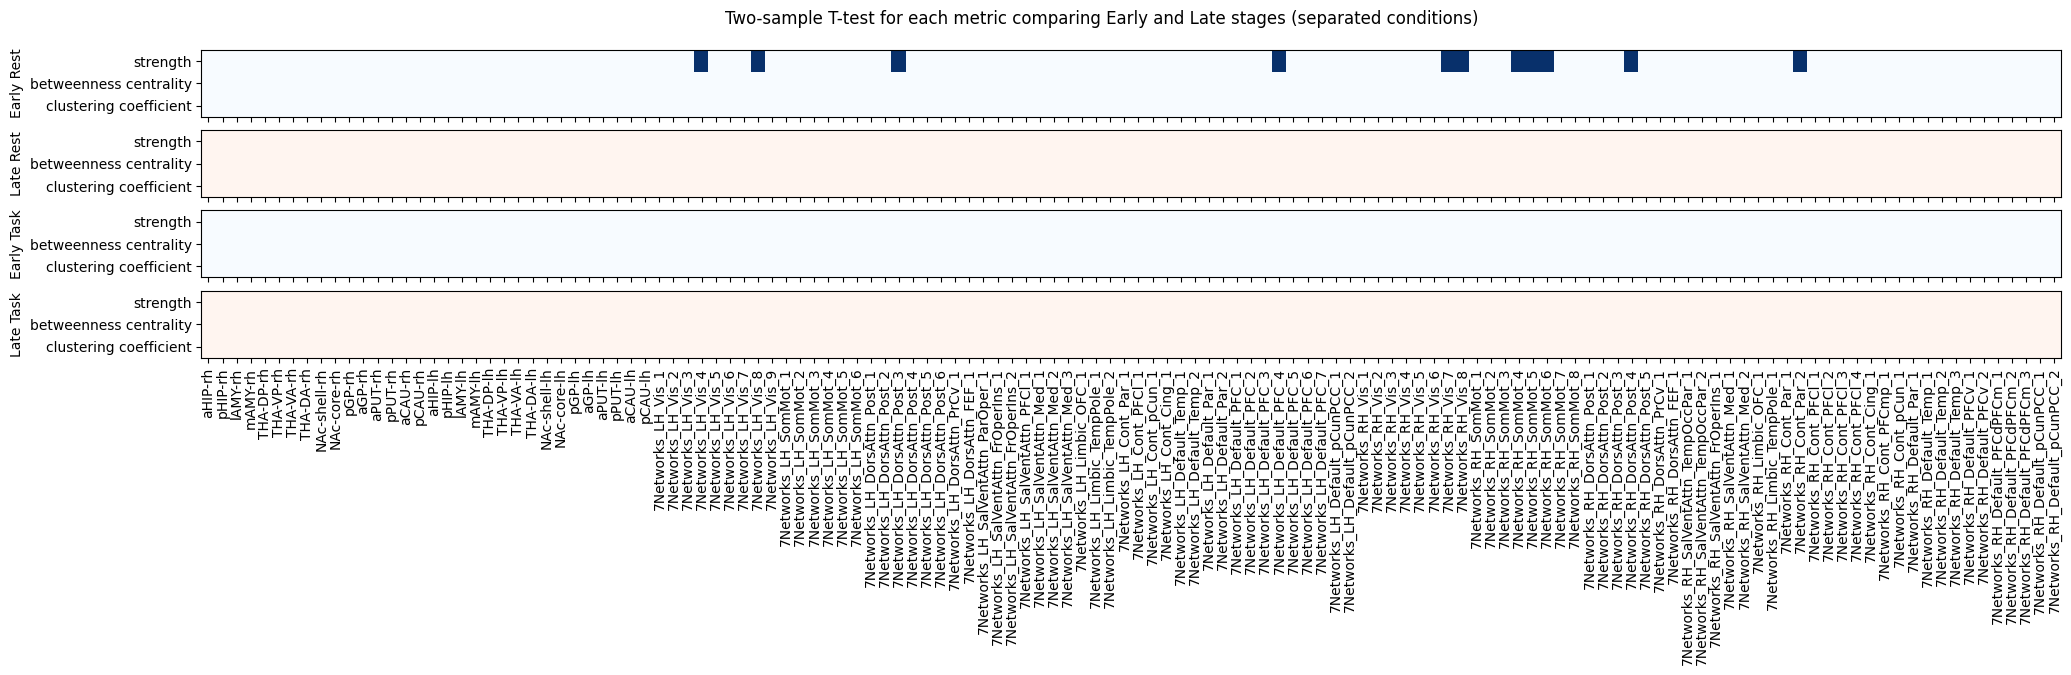

In [ ]:
rest_early_data = adjacency_matrices['rest_early']['mslWithITI'] + adjacency_matrices['rest_early']['mslWithoutITI']
rest_late_data = adjacency_matrices['rest_late']['mslWithITI'] + adjacency_matrices['rest_late']['mslWithoutITI']
task_early_data = adjacency_matrices['task_early']['mslWithITI'] + adjacency_matrices['task_early']['mslWithoutITI']
task_late_data = adjacency_matrices['task_late']['mslWithITI'] + adjacency_matrices['task_late']['mslWithoutITI']

rest_early_metrics = compute_node_metrics(rest_early_data)
rest_late_metrics = compute_node_metrics(rest_late_data)
task_early_metrics = compute_node_metrics(task_early_data)
task_late_metrics = compute_node_metrics(task_late_data)

alpha = 0.05

fig, axs = plt.subplots(4,1,figsize=(24, 4))

early_late_rest_stats = {}
for metric in early_metrics:
    early_late_rest_stats[metric] = {}
    p_vals_early_rest = stats.ttest_ind(rest_early_metrics[metric], rest_late_metrics[metric], alternative='greater').pvalue
    p_vals_late_rest = stats.ttest_ind(rest_early_metrics[metric], rest_late_metrics[metric], alternative='less').pvalue
    p_vals_fdr_early_rest = stats.false_discovery_control(p_vals_early_rest)
    p_vals_fdr_late_rest = stats.false_discovery_control(p_vals_late_rest)
    early_late_rest_stats[metric]['Rest: early > late'] = p_vals_fdr_early_rest
    early_late_rest_stats[metric]['Rest: late > early'] = p_vals_fdr_late_rest

axs[0].imshow([
    early_late_rest_stats['strength']['Rest: early > late'] < alpha,
    early_late_rest_stats['betweenness centrality']['Rest: early > late'] < alpha,
    early_late_rest_stats['clustering coefficient']['Rest: early > late'] < alpha
    ], interpolation='none', aspect='auto', cmap='Blues')
axs[1].imshow([
    early_late_rest_stats['strength']['Rest: late > early'] < alpha,
    early_late_rest_stats['betweenness centrality']['Rest: late > early'] < alpha,
    early_late_rest_stats['clustering coefficient']['Rest: late > early'] < alpha
    ], interpolation='none', aspect='auto', cmap='Reds')

early_late_task_stats = {}
for metric in early_metrics:
    early_late_task_stats[metric] = {}
    p_vals_early_task = stats.ttest_ind(task_early_metrics[metric], task_late_metrics[metric], alternative='greater').pvalue
    p_vals_late_task = stats.ttest_ind(task_early_metrics[metric], task_late_metrics[metric], alternative='less').pvalue
    p_vals_fdr_early_task = stats.false_discovery_control(p_vals_early_task)
    p_vals_fdr_late_task = stats.false_discovery_control(p_vals_late_task)
    early_late_task_stats[metric]['Task: early > late'] = p_vals_fdr_early_task
    early_late_task_stats[metric]['Task: late > early'] = p_vals_fdr_late_task
axs[2].imshow([
    early_late_task_stats['strength']['Task: early > late'] < alpha,
    early_late_task_stats['betweenness centrality']['Task: early > late'] < alpha,
    early_late_task_stats['clustering coefficient']['Task: early > late'] < alpha
    ], interpolation='none', aspect='auto', cmap='Blues')
axs[3].imshow([
    early_late_task_stats['strength']['Task: late > early'] < alpha,
    early_late_task_stats['betweenness centrality']['Task: late > early'] < alpha,
    early_late_task_stats['clustering coefficient']['Task: late > early'] < alpha
    ], interpolation='none', aspect='auto', cmap='Reds')

fig.suptitle('Two-sample T-test for each metric comparing Early and Late stages (separated conditions)')
axs[0].set(yticks=[0,1,2], yticklabels=['strength', 'betweenness centrality', 'clustering coefficient'])
axs[0].set(ylabel='Early Rest')
axs[0].set(xticks=np.arange(len(labels)))
axs[1].set(xticks=np.arange(len(labels)))
axs[2].set(xticks=np.arange(len(labels)))
axs[1].set(yticks=[0,1,2], yticklabels=['strength', 'betweenness centrality', 'clustering coefficient'])
axs[3].set(xticks=np.arange(len(labels)), xticklabels=labels)
axs[2].set(yticks=[0,1,2], yticklabels=['strength', 'betweenness centrality', 'clustering coefficient'])
axs[3].set(yticks=[0,1,2], yticklabels=['strength', 'betweenness centrality', 'clustering coefficient'])
axs[1].set(ylabel='Late Rest')
axs[2].set(ylabel='Early Task')
axs[3].set(ylabel='Late Task')
axs[0].label_outer()
axs[1].label_outer()
axs[2].label_outer()
axs[3].tick_params(axis='x', labelrotation=90)

## Between-groups edge analysis including both conditions (rest and task)

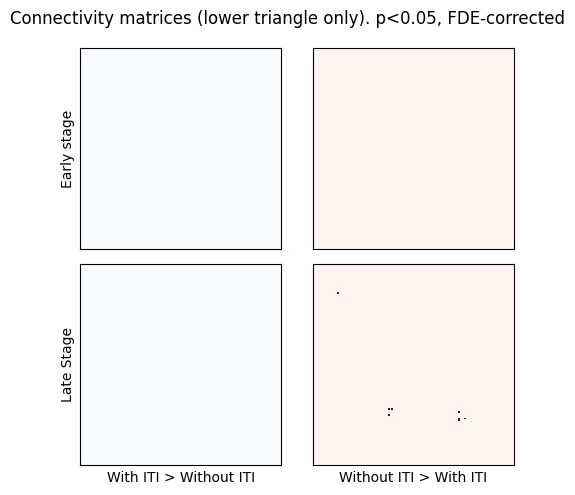

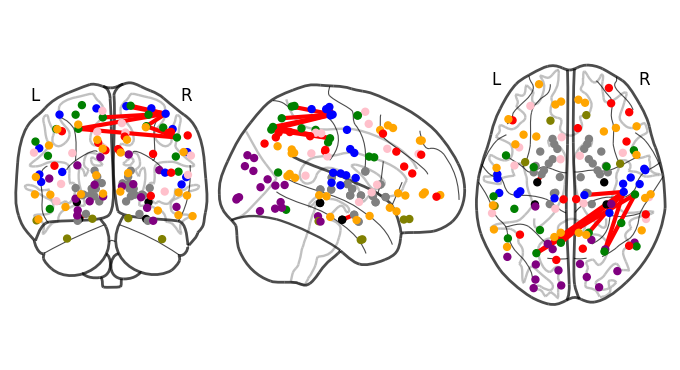

In [ ]:
# Get early and late data for all subjects (lower triangles)
withITI_early_data = np.tril(adjacency_matrices['early']['mslWithITI'])
withoutITI_early_data = np.tril(adjacency_matrices['early']['mslWithoutITI'])
withITI_late_data = np.tril(adjacency_matrices['late']['mslWithITI'])
withoutITI_late_data = np.tril(adjacency_matrices['late']['mslWithoutITI'])

between_groups_results = {
    'Early: withITI>withoutITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_early_data, withoutITI_early_data, alternative='greater').pvalue, nan=1),
    'Early: withoutITI>withITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_early_data, withoutITI_early_data, alternative='less').pvalue, nan=1),
    'Late: withITI>withoutITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_late_data, withoutITI_late_data, alternative='greater').pvalue, nan=1),
    'Late: withoutITI>withITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_late_data, withoutITI_late_data, alternative='less').pvalue, nan=1),
}

between_groups_results['Early: withITI>withoutITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Early: withITI>withoutITI (uncorrected)'])
between_groups_results['Early: withoutITI>withITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Early: withoutITI>withITI (uncorrected)'])
between_groups_results['Late: withITI>withoutITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Late: withITI>withoutITI (uncorrected)'])
between_groups_results['Late: withoutITI>withITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Late: withoutITI>withITI (uncorrected)'])

alpha = 0.05

fig, axs = plt.subplots(2, 2, figsize=(5,5))
fig.suptitle('Connectivity matrices (lower triangle only). p<0.05, FDE-corrected')

axs[0,0].imshow(between_groups_results['Early: withITI>withoutITI (FDE-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[0,1].imshow(between_groups_results['Early: withoutITI>withITI (FDE-corrected)']<alpha, cmap='Reds', interpolation='none')
axs[1,0].imshow(between_groups_results['Late: withITI>withoutITI (FDE-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[1,1].imshow(between_groups_results['Late: withoutITI>withITI (FDE-corrected)']<alpha, cmap='Reds', interpolation='none')

axs[0,0].set(ylabel='Early stage')
axs[1,0].set(ylabel='Late Stage')
axs[1,0].set(xlabel='With ITI > Without ITI')
axs[1,1].set(xlabel='Without ITI > With ITI')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

withITI_late_results = (between_groups_results['Late: withoutITI>withITI (FDE-corrected)'] < alpha) * 1
withITI_late_results = np.triu(withITI_late_results.T,1) + withITI_late_results

plotting.plot_connectome(withITI_late_results,
                         label_coords, node_color=label_colors,
                         node_size=25,)


Between-groups edge analysis segregating by condition (rest and task)

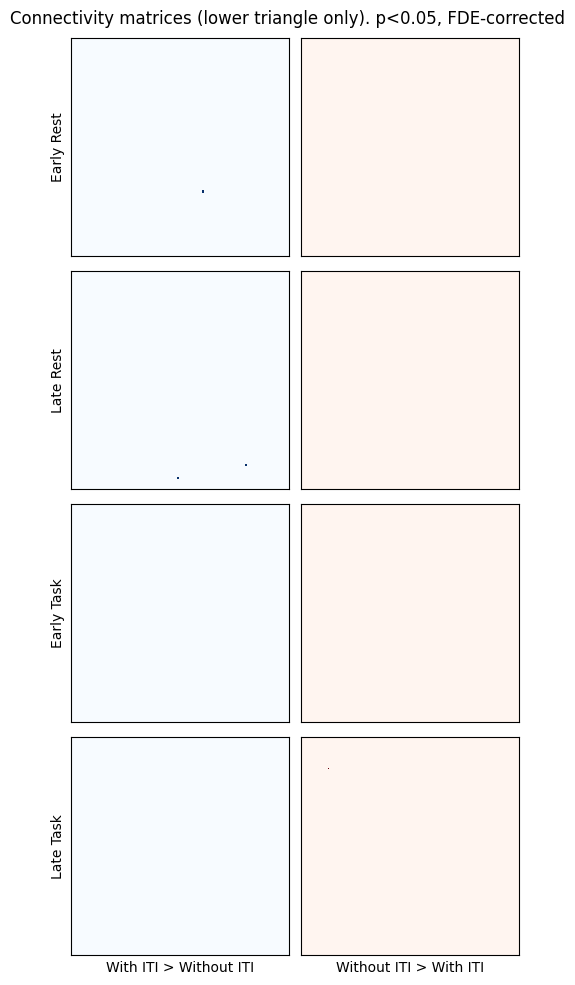

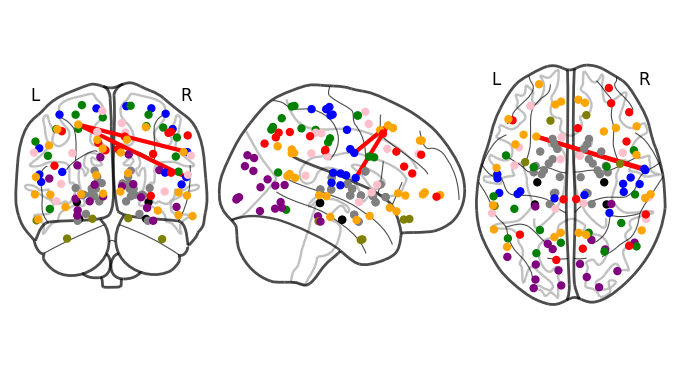

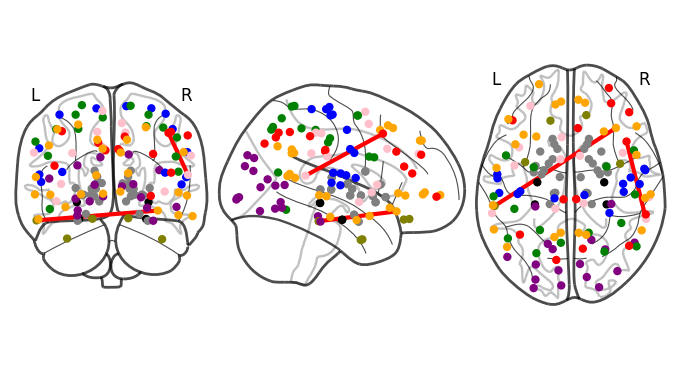

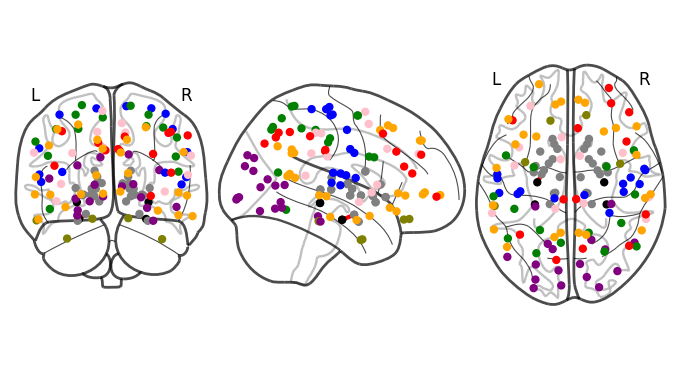

In [ ]:
# Get data for all subjects (lower triangles)
withITI_rest_early_data = np.tril(adjacency_matrices['rest_early']['mslWithITI'])
withITI_task_early_data = np.tril(adjacency_matrices['task_early']['mslWithITI'])
withITI_rest_late_data = np.tril(adjacency_matrices['rest_late']['mslWithITI'])
withITI_task_late_data = np.tril(adjacency_matrices['task_late']['mslWithITI'])

withoutITI_rest_early_data = np.tril(adjacency_matrices['rest_early']['mslWithoutITI'])
withoutITI_task_early_data = np.tril(adjacency_matrices['task_early']['mslWithoutITI'])
withoutITI_rest_late_data = np.tril(adjacency_matrices['rest_late']['mslWithoutITI'])
withoutITI_task_late_data = np.tril(adjacency_matrices['task_late']['mslWithoutITI'])

between_groups_results = {
    'Early Rest: withITI>withoutITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_rest_early_data, withoutITI_rest_early_data, alternative='greater').pvalue, nan=1),
    'Early Rest: withoutITI>withITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_rest_early_data, withoutITI_rest_early_data, alternative='less').pvalue, nan=1),
    'Late Rest: withITI>withoutITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_rest_late_data, withoutITI_rest_late_data, alternative='greater').pvalue, nan=1),
    'Late Rest: withoutITI>withITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_rest_late_data, withoutITI_rest_late_data, alternative='less').pvalue, nan=1),

    'Early Task: withITI>withoutITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_task_early_data, withoutITI_task_early_data, alternative='greater').pvalue, nan=1),
    'Early Task: withoutITI>withITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_task_early_data, withoutITI_task_early_data, alternative='less').pvalue, nan=1),
    'Late Task: withITI>withoutITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_task_late_data, withoutITI_task_late_data, alternative='greater').pvalue, nan=1),
    'Late Task: withoutITI>withITI (uncorrected)': np.nan_to_num(stats.ttest_ind(withITI_task_late_data, withoutITI_task_late_data, alternative='less').pvalue, nan=1),
}

between_groups_results['Early Rest: withITI>withoutITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Early Rest: withITI>withoutITI (uncorrected)'])
between_groups_results['Early Rest: withoutITI>withITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Early Rest: withoutITI>withITI (uncorrected)'])
between_groups_results['Late Rest: withITI>withoutITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Late Rest: withITI>withoutITI (uncorrected)'])
between_groups_results['Late Rest: withoutITI>withITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Late Rest: withoutITI>withITI (uncorrected)'])

between_groups_results['Early Task: withITI>withoutITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Early Task: withITI>withoutITI (uncorrected)'])
between_groups_results['Early Task: withoutITI>withITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Early Task: withoutITI>withITI (uncorrected)'])
between_groups_results['Late Task: withITI>withoutITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Late Task: withITI>withoutITI (uncorrected)'])
between_groups_results['Late Task: withoutITI>withITI (FDE-corrected)'] = stats.false_discovery_control(between_groups_results['Late Task: withoutITI>withITI (uncorrected)'])

alpha = 0.05

fig, axs = plt.subplots(4, 2, figsize=(5,10))
fig.suptitle('Connectivity matrices (lower triangle only). p<0.05, FDE-corrected')

axs[0,0].imshow(between_groups_results['Early Rest: withITI>withoutITI (FDE-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[0,1].imshow(between_groups_results['Early Rest: withoutITI>withITI (FDE-corrected)']<alpha, cmap='Reds', interpolation='none')
axs[1,0].imshow(between_groups_results['Late Rest: withITI>withoutITI (FDE-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[1,1].imshow(between_groups_results['Late Rest: withoutITI>withITI (FDE-corrected)']<alpha, cmap='Reds', interpolation='none')

axs[2,0].imshow(between_groups_results['Early Task: withITI>withoutITI (FDE-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[2,1].imshow(between_groups_results['Early Task: withoutITI>withITI (FDE-corrected)']<alpha, cmap='Reds', interpolation='none')
axs[3,0].imshow(between_groups_results['Late Task: withITI>withoutITI (FDE-corrected)']<alpha, cmap='Blues', interpolation='none')
axs[3,1].imshow(between_groups_results['Late Task: withoutITI>withITI (FDE-corrected)']<alpha, cmap='Reds', interpolation='none')

axs[0,0].set(ylabel='Early Rest')
axs[1,0].set(ylabel='Late Rest')
axs[2,0].set(ylabel='Early Task')
axs[3,0].set(ylabel='Late Task')
axs[3,0].set(xlabel='With ITI > Without ITI')
axs[3,1].set(xlabel='Without ITI > With ITI')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

withITI_early_rest_result = (between_groups_results['Early Rest: withITI>withoutITI (FDE-corrected)']<alpha)*1
withITI_early_rest_result = withITI_early_rest_result + np.triu(withITI_early_rest_result.T, 1)
withITI_late_rest_result = (between_groups_results['Late Rest: withITI>withoutITI (FDE-corrected)']<alpha)*1
withITI_late_rest_result = withITI_late_rest_result + np.triu(withITI_late_rest_result.T, 1)
withoutITI_late_task_result = (between_groups_results['Late Task: withoutITI>withITI (FDE-corrected)']<alpha)*1
withoutITI_late_task_result = withoutITI_late_task_result + np.triu(withoutITI_late_task_result.T, 1)

plotting.plot_connectome(withITI_early_rest_result, label_coords, node_size=25, node_color=label_colors)
plt.show()
plotting.plot_connectome(withITI_late_rest_result, label_coords, node_size=25, node_color=label_colors)
plt.show()
plotting.plot_connectome(withoutITI_late_task_result, label_coords, node_size=25, node_color=label_colors)
plt.show()
